In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import regex as re
from shutil import copyfile

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
image_path = "all_files"

image_size = (71, 71)
image_size_rgb = (71, 71)

batch_size = 32
seeds = 42

num_classes = 8

validation_s = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
train_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    # label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 15047 files belonging to 8 classes.
Using 12038 files for training.


2022-01-23 16:07:11.838806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 16:07:12.892758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-23 16:07:12.892785: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 15047 files belonging to 8 classes.
Using 3009 files for validation.
Found 15047 files belonging to 8 classes.
Using 12038 files for training.
Found 15047 files belonging to 8 classes.
Using 3009 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['10', '12', '1235', '15', '17', '2', '21', '38']


In [5]:
buffer_size = 32

train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)

train_ds_rgb = train_ds_rgb.prefetch(buffer_size=buffer_size)
val_ds_rgb = val_ds_rgb.prefetch(buffer_size=buffer_size)

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


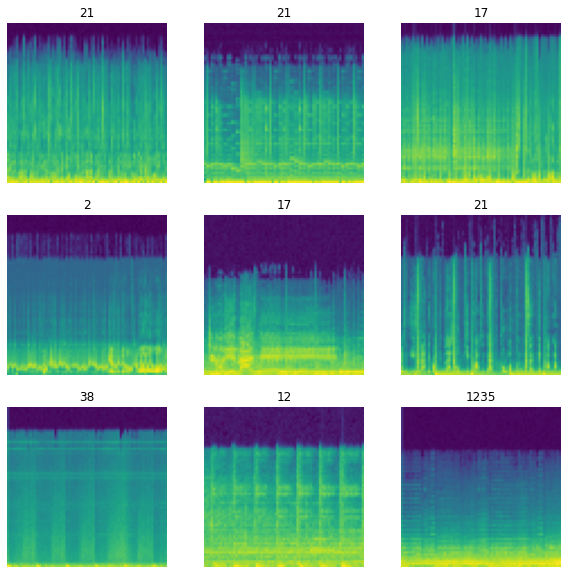

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
## Model parameters:
main_activation = "relu"
last_activation = "softmax"
bias = True
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = None
rescaling_layer = layers.Rescaling(scale=1.0 / 255)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3))

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-01-23 16:07:30.114403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 62 of 1000
2022-01-23 16:07:40.157449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 119 of 1000
2022-01-23 16:07:50.115359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 188 of 1000
2022-01-23 16:08:00.047171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 249 of 1000
2022-01-23 16:08:09.995426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 316 of 1000


0.3631822 0.95100796


2022-01-23 16:08:17.886237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [11]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 71, 71, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 71, 71, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 64)        1

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# epochs=20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [14]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(16, 3, padding='same', activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    x = layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71, 71, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 71, 71, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                         

In [15]:
model_bas.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# epochs=20
# history = model_bas.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [17]:
epochs = 15
# l_r = 0.0005



def modell_fit_val(models,model_names,l_r = 0.001,chanels = 1):
    if chanels == 1:
        fit_train_ds = train_ds
        fit_val_ds = val_ds
    elif chanels == 3:
        fit_train_ds = train_ds_rgb
        fit_val_ds = val_ds_rgb

    #compile parameters

    models_test_acc = []
    for models, model_name in zip(models,model_names):
        
        opt = keras.optimizers.Adam(learning_rate=l_r)
        batch_size = 32
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        save_dir = "saves/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=4, min_delta=0.01,
            verbose=1
        )
        callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir + "_{epoch}.h5"),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        reducelr_callback]

        print("Training model: {} with learning rate: {}".format(model_name,l_r))

        models.compile(
            # optimizer=keras.optimizers.Adam(),
            optimizer=opt,
            loss=loss,
            metrics=["accuracy"]
        )
        models.fit(
            fit_train_ds, epochs=epochs, callbacks=callbacks, 
            validation_data=fit_val_ds, shuffle=True
        )
        test_loss, test_acc = models.evaluate(fit_val_ds, verbose=2)
        models_test_acc.append(test_acc)

    for counter, acc in enumerate(models_test_acc):
        print("the {}. model has an accuracyŰ of {}".format(counter,acc))

In [18]:
modell_fit_val([model,model_bas],["model","model_bas"],l_r=0.001)

Training model: model with learning rate: 0.001
Epoch 1/15
377/377 [==============================] - 55s 141ms/step - loss: 1.9913 - accuracy: 0.2159 - val_loss: 1.8823 - val_accuracy: 0.2908 - lr: 0.0010
Epoch 2/15
377/377 [==============================] - 36s 96ms/step - loss: 1.7386 - accuracy: 0.3465 - val_loss: 1.5909 - val_accuracy: 0.4088 - lr: 0.0010
Epoch 3/15
377/377 [==============================] - 33s 89ms/step - loss: 1.4878 - accuracy: 0.4661 - val_loss: 1.4041 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 4/15
377/377 [==============================] - 34s 90ms/step - loss: 1.2481 - accuracy: 0.5575 - val_loss: 1.1817 - val_accuracy: 0.5945 - lr: 0.0010
Epoch 5/15
377/377 [==============================] - 35s 93ms/step - loss: 1.0216 - accuracy: 0.6463 - val_loss: 0.9871 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 6/15
377/377 [==============================] - 34s 90ms/step - loss: 0.8123 - accuracy: 0.7203 - val_loss: 0.8285 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 7/1

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units)(x)
    return keras.Model(inputs, outputs)


model_keras = make_model(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)

In [20]:
model_keras.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
# epochs=10
# history = model_keras.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [22]:
def make_model_im_net(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    inputs = layers.Rescaling(1.0 / 255)(inputs)

    input_shape_rgb = (input_shape[0], input_shape[1], 3)

    base_model = tf.keras.applications.Xception(input_shape = input_shape_rgb,
                                            include_top=False,
                                            weights='imagenet'
                                            
                                            )

    base_model.trainable = False

    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu", use_bias=True)(x)
    x = layers.Dense(64, activation="relu", use_bias=True)(x)
    outputs = layers.Dense(units)(x)
    return keras.Model(inputs,outputs)

model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)

In [23]:
model_im_net.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# epochs=10
# history = model_im_net.fit(
#   train_ds_rgb,
#   validation_data=val_ds_rgb,
#   epochs=epochs)